In [1]:
import cv2
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
import scipy.ndimage
import warnings

%matplotlib inline

In [2]:
import pycocotools

In [3]:
class_heirarchy_fp = "./bbox_labels_600_hierarchy.json"
id_label_fp = "./class-descriptions-boxable.csv"
trainable_segmentation_fp = "./classes-segmentation.txt"

type_v = "train"

if type_v == "train":
    img_base_fp = "./train_f/"
    tmp_img_base_fp = "./tmp_train_f/"
    tmp_mask_base_fp = "./tmp_masks_f/"
    mask_base_fp = "./train_masks_f/"
    rsz_img_base_fp = "./rsz_train_f/"
    rsz_mask_base_fp = "./rsz_train_masks_f/"
    output_coco_json_fp = "instances_openimagev5tococo_train2020.json"
elif type_v == "val":
    img_base_fp = "./validation/"
    tmp_img_base_fp = "./tmp_validation/"
    tmp_mask_base_fp = "./tmp_validation_masks_f/"
    mask_base_fp = "./validation_masks_f/"
    rsz_img_base_fp = "./rsz_validation_f/"
    rsz_mask_base_fp = "./rsz_validation_masks_f/"
    output_coco_json_fp = "instances_openimagev5tococo_val2020.json"


img_extension = ".jpg"

mask_extension = ".png"



IMAGE_MIN_DIM = 800
IMAGE_MAX_DIM = 1024

coco_max_index = 0



In [4]:
def cv2plt(img):
    plt.axis('on')
    if np.size(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)
    plt.show()

def resize_image(image, min_dim=None, max_dim=None, padding=False):
    """
    Resizes an image keeping the aspect ratio.
    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    padding: If true, pads image with zeros so it's size is max_dim x max_dim
    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    # Does it exceed max dim?
    if max_dim:
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max
    # Resize image and mask
    if scale != 1:
        image = scipy.misc.imresize(
            image, (round(h * scale), round(w * scale)))
    # Need padding?
    if padding:
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    return image, window, scale, padding


def resize_mask(mask, scale, padding):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.
    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask

def load_hierarchy_children(hierarchy):
    res = [hierarchy['LabelName']]

    if 'Subcategory' in hierarchy:
        for subcategory in hierarchy['Subcategory']:
            children = load_hierarchy_children(subcategory)

            for c in children:
                res.append(c)
                
    return res

def load_hierarchy_children2(hierarchy):
    res = [hierarchy['LabelName']]

    if 'Part' in hierarchy:
        for subpart in hierarchy['Part']:
            children = load_hierarchy_children(subpart)

            for c in children:
                res.append(c)
                
    return res

def find_hierarchy_parent(hierarchy, parent_cls):
    if hierarchy['LabelName'] == parent_cls:
        return hierarchy
    elif 'Subcategory' in hierarchy:
        for child in hierarchy['Subcategory']:
            res = find_hierarchy_parent(child, parent_cls)
            if res is not None:
                return res

    return None

# Test: Reading the json and extracting desired categories

In [5]:
with open(class_heirarchy_fp, 'r') as f:
    class_heirarchy_dict = json.load(f)

In [6]:
id_label_df = pd.read_csv(id_label_fp, names=["id", "label"])

In [7]:
id_label_df.head()

,id,label
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [8]:
id_label_dict = {"/m/0bl9f":"Entity"}
for i in range(len(id_label_df)):
    id_val, label_val = id_label_df.iloc[i]
    id_label_dict[id_val] = label_val

In [9]:
desired_labels = ["Clothing", "Vehicle", "Person"]

In [10]:
label_id_dict = {v: k for k, v in id_label_dict.items()}

In [11]:
desired_parent_ids = []
for label in desired_labels:
    desired_parent_ids.append(label_id_dict[label])

In [12]:
desired_parent_ids

['/m/09j2d', '/m/07yv9', '/m/01g317']

In [13]:
for i in range(len(class_heirarchy_dict["Subcategory"])):
    if class_heirarchy_dict["Subcategory"][i]["LabelName"] == "/m/09j2d":
        print("Found, %s" %(i))

Found, 43


In [14]:
class_heirarchy_dict["Subcategory"][43]

{'LabelName': '/m/09j2d',
 'Subcategory': [{'LabelName': '/m/01bfm9'},
  {'LabelName': '/m/01d40f'},
  {'LabelName': '/m/01gkx_'},
  {'LabelName': '/m/01gmv2'},
  {'LabelName': '/m/01krhy'},
  {'LabelName': '/m/01n4qj'},
  {'LabelName': '/m/01xygc'},
  {'LabelName': '/m/01xyhv'},
  {'LabelName': '/m/02dl1y',
   'Subcategory': [{'LabelName': '/m/025rp__'},
    {'LabelName': '/m/02fq_6'},
    {'LabelName': '/m/02jfl0'},
    {'LabelName': '/m/02wbtzl'}]},
  {'LabelName': '/m/02h19r'},
  {'LabelName': '/m/02wv6h6', 'Subcategory': [{'LabelName': '/m/01cmb2'}]},
  {'LabelName': '/m/032b3c'},
  {'LabelName': '/m/0463sg',
   'Subcategory': [{'LabelName': '/m/0174n1',
     'Subcategory': [{'LabelName': '/m/03grzl'}]},
    {'LabelName': '/m/0176mf'},
    {'LabelName': '/m/017ftj'},
    {'LabelName': '/m/01krhy'},
    {'LabelName': '/m/01llwg'},
    {'LabelName': '/m/01nq26'},
    {'LabelName': '/m/01r546'},
    {'LabelName': '/m/01rkbr'},
    {'LabelName': '/m/02_n6y'},
    {'LabelName': '/m/02d

In [15]:
desired_children_ids = []

for id_val in desired_parent_ids:
    heirarchy_dict = find_hierarchy_parent(class_heirarchy_dict, id_val)
    if heirarchy_dict is not None:
        children = load_hierarchy_children(heirarchy_dict)
        for child in children:
            desired_children_ids.append([child, id_val])

In [16]:
desired_children_ids

[['/m/09j2d', '/m/09j2d'],
 ['/m/01bfm9', '/m/09j2d'],
 ['/m/01d40f', '/m/09j2d'],
 ['/m/01gkx_', '/m/09j2d'],
 ['/m/01gmv2', '/m/09j2d'],
 ['/m/01krhy', '/m/09j2d'],
 ['/m/01n4qj', '/m/09j2d'],
 ['/m/01xygc', '/m/09j2d'],
 ['/m/01xyhv', '/m/09j2d'],
 ['/m/02dl1y', '/m/09j2d'],
 ['/m/025rp__', '/m/09j2d'],
 ['/m/02fq_6', '/m/09j2d'],
 ['/m/02jfl0', '/m/09j2d'],
 ['/m/02wbtzl', '/m/09j2d'],
 ['/m/02h19r', '/m/09j2d'],
 ['/m/02wv6h6', '/m/09j2d'],
 ['/m/01cmb2', '/m/09j2d'],
 ['/m/032b3c', '/m/09j2d'],
 ['/m/0463sg', '/m/09j2d'],
 ['/m/0174n1', '/m/09j2d'],
 ['/m/03grzl', '/m/09j2d'],
 ['/m/0176mf', '/m/09j2d'],
 ['/m/017ftj', '/m/09j2d'],
 ['/m/01krhy', '/m/09j2d'],
 ['/m/01llwg', '/m/09j2d'],
 ['/m/01nq26', '/m/09j2d'],
 ['/m/01r546', '/m/09j2d'],
 ['/m/01rkbr', '/m/09j2d'],
 ['/m/02_n6y', '/m/09j2d'],
 ['/m/02dl1y', '/m/09j2d'],
 ['/m/025rp__', '/m/09j2d'],
 ['/m/02fq_6', '/m/09j2d'],
 ['/m/02jfl0', '/m/09j2d'],
 ['/m/02wbtzl', '/m/09j2d'],
 ['/m/02h19r', '/m/09j2d'],
 ['/m/080hkjn', 

In [39]:
desired_children_ids_df = pd.DataFrame(desired_children_ids, columns=["id", "parent_id"], dtype = str)

In [40]:
desired_children_ids_df

,id,parent_id
0,/m/09j2d,/m/09j2d
1,/m/01bfm9,/m/09j2d
2,/m/01d40f,/m/09j2d
3,/m/01gkx_,/m/09j2d
4,/m/01gmv2,/m/09j2d
...,...,...
87,/m/01g317,/m/01g317
88,/m/04yx4,/m/01g317
89,/m/03bt1vf,/m/01g317
90,/m/01bl7v,/m/01g317


In [41]:
trainable_segmentation_ids_df = pd.read_csv(trainable_segmentation_fp, names= ["id"])

In [42]:
trainable_segmentation_ids_df

,id
0,/m/01_5g
1,/m/0c06p
2,/m/01lsmm
3,/m/01bqk0
4,/m/0l14j_
...,...
345,/m/01226z
346,/m/014j1m
347,/m/0c3m8g
348,/m/044r5d


In [43]:
# trainable_segmentation_ids_df = pd.DataFrame(segmentation, columns=["id"], dtype = str)

In [44]:
desired_segmentation_ids_df = desired_children_ids_df.merge(trainable_segmentation_ids_df, on="id", how="inner")

In [45]:
desired_segmentation_ids_df = desired_segmentation_ids_df.merge(id_label_df, on="id", how="left")

In [46]:
desired_segmentation_ids_df.drop_duplicates(subset=None, keep='first', inplace=True) #Strange there were duplicate ids...

In [47]:
desired_segmentation_ids_df = desired_segmentation_ids_df[desired_segmentation_ids_df["id"] != desired_segmentation_ids_df["parent_id"]].reset_index()

In [48]:
desired_segmentation_ids_df = desired_segmentation_ids_df.drop(columns="index")

In [49]:
desired_segmentation_ids_df

,id,parent_id,label
0,/m/01bfm9,/m/09j2d,Shorts
1,/m/01d40f,/m/09j2d,Dress
2,/m/01gkx_,/m/09j2d,Swimwear
3,/m/01n4qj,/m/09j2d,Shirt
4,/m/01xyhv,/m/09j2d,Suit
5,/m/02dl1y,/m/09j2d,Hat
6,/m/025rp__,/m/09j2d,Cowboy hat
7,/m/02fq_6,/m/09j2d,Fedora
8,/m/02jfl0,/m/09j2d,Sombrero
9,/m/02wbtzl,/m/09j2d,Sun hat


In [50]:
tmp_id_label_df = id_label_df
tmp_id_label_df = tmp_id_label_df.rename(columns={"id": "parent_id", "label": "parent_label"})
desired_segmentation_ids_df = desired_segmentation_ids_df.merge(tmp_id_label_df, on="parent_id", how="left")

In [51]:
desired_segmentation_ids_df

,id,parent_id,label,parent_label
0,/m/01bfm9,/m/09j2d,Shorts,Clothing
1,/m/01d40f,/m/09j2d,Dress,Clothing
2,/m/01gkx_,/m/09j2d,Swimwear,Clothing
3,/m/01n4qj,/m/09j2d,Shirt,Clothing
4,/m/01xyhv,/m/09j2d,Suit,Clothing
5,/m/02dl1y,/m/09j2d,Hat,Clothing
6,/m/025rp__,/m/09j2d,Cowboy hat,Clothing
7,/m/02fq_6,/m/09j2d,Fedora,Clothing
8,/m/02jfl0,/m/09j2d,Sombrero,Clothing
9,/m/02wbtzl,/m/09j2d,Sun hat,Clothing


In [52]:
desired_segmentation_ids_df["id_remove_slash"] = desired_segmentation_ids_df.apply(lambda x: x["id"].replace("/", ""), axis=1)

In [58]:
# In the end we're only going to take ["Dress", "Suit", "Jeans"]
desired_segmentation_ids_df = desired_segmentation_ids_df[desired_segmentation_ids_df["label"].isin(["Dress", "Suit", "Jeans"])]

In [59]:
desired_segmentation_ids_df["index"] = [x+1+coco_max_index for x in range(len(desired_segmentation_ids_df))]

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\mask_rcnn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
desired_segmentation_ids_df

,id,parent_id,label,parent_label,id_remove_slash,index
1,/m/01d40f,/m/09j2d,Dress,Clothing,m01d40f,1
4,/m/01xyhv,/m/09j2d,Suit,Clothing,m01xyhv,2
22,/m/0fly7,/m/09j2d,Jeans,Clothing,m0fly7,3


In [61]:
final_segmentation_metadata = desired_segmentation_ids_df

In [62]:
final_segmentation_metadata.to_csv("final_segmentation_metadata.csv", header=True, index=False)

In [63]:
final_segmentation_metadata

,id,parent_id,label,parent_label,id_remove_slash,index
1,/m/01d40f,/m/09j2d,Dress,Clothing,m01d40f,1
4,/m/01xyhv,/m/09j2d,Suit,Clothing,m01xyhv,2
22,/m/0fly7,/m/09j2d,Jeans,Clothing,m0fly7,3


# Test: Getting the filepaths...

In [64]:
i=0
running_image_id=0
pattern = final_segmentation_metadata.iloc[i]["id_remove_slash"]
pattern

'm01d40f'

In [65]:
mask_img_fps = glob.glob(mask_base_fp + "*" + pattern + "*")

In [79]:
j=1
msk_fp = mask_img_fps[j]
# msk_fp = "./train_masks_f/f00a028c08bbc3ce_m0fly7_445a8b43.png"

In [80]:
img_name = msk_fp.split("/")[-1].split("\\")[-1].split("_")[0] # This looks rly fragile...

In [81]:
col_img_fps = glob.glob(img_base_fp + "*" + img_name + "*")[0] # There should only be one image, multiple masks but 1 image

In [82]:
col_img = cv2.imread(col_img_fps)

In [83]:
msk_img = cv2.imread(msk_fp, 0)

# Test: Reshaping the Images & Masks

In [84]:
#col_img = cv2.imread("./train_f/f0000bedb73d28fc.jpg")  #Test Case 1
#col_img = cv2.imread("./train_f/f000dd567518972e.jpg")  #Test Case 2
#col_img = cv2.imread("./train_f/f000b96493426cfd.jpg")  #Test Case 3
#col_img = cv2.imread("./train_f/f00cd1ea048ddaec.jpg")  #Test Case 4
#col_img = cv2.imread("./train_f/f00e5e88017a5623.jpg")  #Test Case 5

In [85]:
#msk_img = cv2.imread("./train-masks-f/f0000bedb73d28fc_m01g317_30a7453e.png", 0)   #Test Case 1
#msk_img = cv2.imread("./train-masks-f/f0000bedb73d28fc_m02dl1y_c638f755.png", 0)   #Test Case 1, diff mask
#msk_img = cv2.imread("./train-masks-f/f000dd567518972e_m04yx4_aae125bc.png", 0)    #Test Case 2
#msk_img = cv2.imread("./train-masks-f/f000b96493426cfd_m04dr76w_58bdc104.png", 0)  #Test Case 3
#msk_img = cv2.imread("./train-masks-f/f00cd1ea048ddaec_m05r655_c2f2a938.png", 0)  #Test Case 4
#msk_img = cv2.imread("./train-masks-f/f00e5e88017a5623_m05r655_65aff3bd.png", 0)  #Test Case 5
#msk_img = cv2.imread("./train-masks-f/f00e5e88017a5623_m0fly7_b7190357.png", 0)  #Test Case 5, diff mask
#msk_img = cv2.imread("./train-masks-f/f00e5e88017a5623_m0fly7_39a01470.png", 0)  #Test Case 5, diff mask

In [86]:
rsz_col_img, window, tmp_scale, tmp_padding = resize_image(col_img, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=True)
stk_msk_img = np.dstack((msk_img, msk_img, msk_img))
tmp_rsz_msk_img, window, tmp_scale, tmp_padding = resize_image(stk_msk_img, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=True)
rsz_msk_img = np.array(tmp_rsz_msk_img[:,:,1])

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\mask_rcnn\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [87]:
print("Original shapes are: %s, %s" %(col_img.shape, msk_img.shape))
print("Transformed shapes are: %s, %s" %(rsz_col_img.shape, rsz_msk_img.shape))

Original shapes are: (1024, 680, 3), (1600, 1063)
Transformed shapes are: (1024, 1024, 3), (1024, 1024)


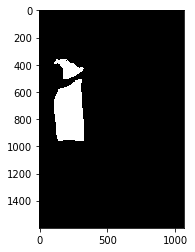

In [88]:
plt.imshow(msk_img, cmap='gray',vmin=0,vmax=255)
plt.show()

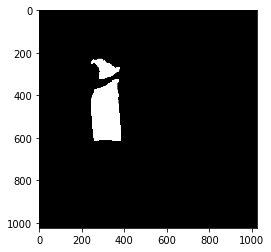

In [89]:
plt.imshow(rsz_msk_img, cmap='gray',vmin=0,vmax=255)
plt.show()

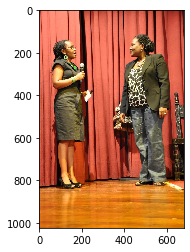

In [90]:
cv2plt(col_img)

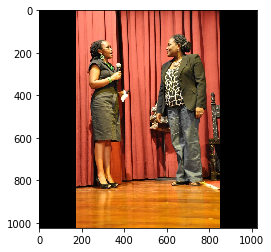

In [91]:
cv2plt(rsz_col_img)

In [92]:
# cv2 for 3.X gives (img, cont, heir), but cv2 for 4.X gives (cont, heir)
cont = cv2.findContours(rsz_msk_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[-2] #CHAIN_APPROX_NONE)

In [93]:
tmp_cont_index = list(range(len(cont)))

max_y = float( max([max(cont[i][:,0][:,1]) for i in tmp_cont_index]) )
min_y = float( min([min(cont[i][:,0][:,1]) for i in tmp_cont_index]) )
max_x = float( max([max(cont[i][:,0][:,0]) for i in tmp_cont_index]) )
min_x = float( min([min(cont[i][:,0][:,0]) for i in tmp_cont_index]) )

print(max_y, min_y, max_x, min_x)

616.0 226.0 384.0 242.0


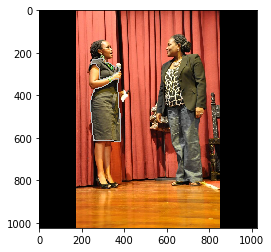

In [94]:
cont_img = cv2.drawContours(rsz_col_img, cont, -1, (191, 191, 191), 3)
cv2plt(cont_img)

In [95]:
print((int(min_x),int(min_y)), (int(max_x),int(max_y)))

(242, 226) (384, 616)


In [96]:
# min_x = 296
# max_x = 808
# min_y = 539
# max_y = 400

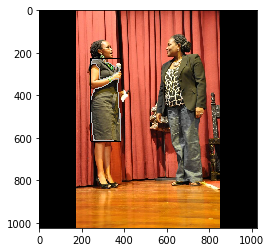

In [97]:
box_cont_img = cv2.rectangle(cont_img, (int(min_x),int(min_y)), (int(max_x),int(max_y)), 3, 2) 
cv2plt(box_cont_img)

In [ ]:
# box_cont_img
cv2.imwrite("test.jpg", box_cont_img)

In [ ]:
cv2.__version__

# Test: Writing out to COCO Style

In [ ]:
final_segmentation_metadata

In [ ]:
# see: http://cocodataset.org/#format-data

In [ ]:
"""
FORMAT IS ...
"info": {
    "description": "COCO 2017 Dataset",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2017,
    "contributor": "COCO Consortium",
    "date_created": "2017/09/01"
}
"""
coco_info = {
    "description": "OpenImage to COCO dataset",
    "url": "https://storage.googleapis.com/openimages/web/download_v5.html",
    "version": "1.0",
    "year": 2019,
    "contributor": "...",
    "date_created": "2020/02/03"
}

In [ ]:
"""
FORMAT IS ...
"licenses": [
    {
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License"
    },
    {
        "url": "http://creativecommons.org/licenses/by-nc/2.0/",
        "id": 2,
        "name": "Attribution-NonCommercial License"
    },
    ...
]
"""

coco_licenses = [
]

In [ ]:
"""
FORMAT IS ...
"images": [
    {
        "license": 4,
        "file_name": "000000397133.jpg",
        "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
        "height": 427,
        "width": 640,
        "date_captured": "2013-11-14 17:02:52",
        "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
        "id": 397133
    },
    ...
]
"""
coco_images = []

In [ ]:
license_val = -1
file_name_val = img_name+img_extension
coco_url_val = "-1"
height_val = IMAGE_MAX_DIM
width_val = IMAGE_MAX_DIM
date_captured_val = "-1"
flickr_url_val = "-1"
id_val = running_image_id

tmp_dict ={
        "license": license_val,
        "file_name": file_name_val,
        "coco_url": coco_url_val,
        "height": height_val,
        "width": width_val,
        "date_captured": date_captured_val,
        "flickr_url": flickr_url_val,
        "id": id_val
}
coco_images.append(tmp_dict)

In [ ]:
"""
FORMAT IS ...
"categories": [
    {"supercategory": "person","id": 1,"name": "person"},
    ...
]"""
coco_categories = []

In [ ]:
for i in range(len(final_segmentation_metadata)):
    tmp_dict = {
        "supercategory":final_segmentation_metadata.iloc[i]["parent_label"],
        "id":final_segmentation_metadata.iloc[i]["index"],
        "name":final_segmentation_metadata.iloc[i]["label"]
               }
    coco_categories.append(tmp_dict)

coco_categories

In [ ]:
"""
FORMAT IS ...
"annotations": [
    {
        "segmentation": [[510.66,423.01,511.72,420.03,...,510.45,423.01]],
        "area": 702.1057499999998,
        "iscrowd": 0,
        "image_id": 289343,
        "bbox": [473.07,395.93,38.65,28.67],
        "category_id": 18,
        "id": 1768
    },
    ...
]
"""
coco_annotations = []

In [ ]:
segmentation_val = [[x.flatten().tolist() for x in cont]] # Flatten the numpy array, puts it in [x,y,x,y,x,y...]
area_val = sum(sum(rsz_msk_img))             # Works because mask is all 1 or 0
iscrowd_val = 0
image_id_val = running_image_id
max_y = float(max(cont[0][:,0][:,1]))
min_y = float(min(cont[0][:,0][:,1]))
max_x = float(max(cont[0][:,0][:,0]))
min_x = float(min(cont[0][:,0][:,0]))
bbox_val = [min_x, min_y, max_x-min_x, max_y-min_y] # [x,y,width,height]
category_id_val = final_segmentation_metadata.iloc[i]["index"]
id_val = -1

tmp_dict ={
        "segmentation": segmentation_val,
        "area": area_val,
        "iscrowd": iscrowd_val,
        "image_id": image_id_val,
        "bbox": bbox_val,
        "category_id": category_id_val,
        "id": id_val
}
coco_annotations.append(tmp_dict)
# see: http://cocodataset.org/#format-data

In [ ]:
# coco_format_fp = "./annotations_trainval2017/annotations/instances_train2017.json"
# with open(coco_format_fp, 'r') as f:
#     coco_format_dict = json.load(f)

In [ ]:
# coco_format_dict["annotations"][0]

# Putting it all together

In [5]:
final_segmentation_metadata = pd.read_csv("final_segmentation_metadata.csv", header=0)

In [6]:
final_segmentation_metadata

,id,parent_id,label,parent_label,id_remove_slash,index
0,/m/01d40f,/m/09j2d,Dress,Clothing,m01d40f,1
1,/m/01xyhv,/m/09j2d,Suit,Clothing,m01xyhv,2
2,/m/0fly7,/m/09j2d,Jeans,Clothing,m0fly7,3


In [7]:
id_remove_slash_to_index_dict = {}
for i in range(len(final_segmentation_metadata)):
    id_remove_slash = final_segmentation_metadata.iloc[i]["id_remove_slash"]
    index = final_segmentation_metadata.iloc[i]["index"]
    id_remove_slash_to_index_dict[id_remove_slash] = index

id_remove_slash_to_index_dict

{'m01d40f': 1, 'm01xyhv': 2, 'm0fly7': 3}

In [8]:
# Creating the folders as necessary

if os.path.isdir(img_base_fp) is False:
    print("Creating folder %s" %(img_base_fp))
    os.mkdir(img_base_fp)
if os.path.isdir(tmp_img_base_fp) is False:
    print("Creating Temp folder %s" %(tmp_img_base_fp))
    os.mkdir(tmp_img_base_fp)
if os.path.isdir(tmp_mask_base_fp) is False:
    print("Creating Temp folder %s" %(tmp_mask_base_fp))
    os.mkdir(tmp_mask_base_fp)
if os.path.isdir(mask_base_fp) is False:
    print("Creating folder %s" %(mask_base_fp))
    os.mkdir(mask_base_fp)
if os.path.isdir(rsz_img_base_fp) is False:
    print("Creating folder %s" %(rsz_img_base_fp))
    os.mkdir(rsz_img_base_fp)
if os.path.isdir(rsz_mask_base_fp) is False:
    print("Creating folder %s" %(rsz_mask_base_fp))
    os.mkdir(rsz_mask_base_fp)

In [9]:
# For every mask related to the various selected labels, put the images & masks into a tmp folders

for i in range(len(final_segmentation_metadata)):
    pattern = final_segmentation_metadata.iloc[i]["id_remove_slash"]
    
    # Find the masks for the given pattern
    mask_img_fps = glob.glob(mask_base_fp + "*" + pattern + "*")
    label1 = final_segmentation_metadata.iloc[i]["label"]
    print("For %s: %s, there are %s mask counts" %(pattern, label1, len(mask_img_fps)))
    for j in range(len(mask_img_fps)):
        msk_fp = mask_img_fps[j]
        img_name = msk_fp.split("/")[-1].split("\\")[-1].split("_")[0] # This looks rly fragile...
        col_img_fps = glob.glob(img_base_fp + "*" + img_name + "*")[0] # There should only be one image, multiple masks but 1 image
        
        #print("Reading in %s now" %(col_img_fps))
        col_img = cv2.imread(col_img_fps)
        msk_img = cv2.imread(msk_fp, 0)
        
        image_name = col_img_fps.split("/")[-1].split("\\")[-1]
        mask_name = msk_fp.split("/")[-1].split("\\")[-1]
        cv2.imwrite(tmp_img_base_fp + image_name, col_img)
        cv2.imwrite(tmp_mask_base_fp + mask_name, msk_img)

For m01d40f: Dress, there are 292 mask counts
For m01xyhv: Suit, there are 522 mask counts
For m0fly7: Jeans, there are 288 mask counts


In [10]:
# For every image placed into the tmp folder, find all the related masks and create the annotation json

coco_images = []
coco_annotations = []

col_img_fps = glob.glob(tmp_img_base_fp + "*") # Because we only want the selected images 
for image_index in range(len(col_img_fps)):
    #image_index = 0
    col_img_fp = col_img_fps[image_index]

    img_name = col_img_fp.split("/")[-1].split("\\")[-1].split(".")[0]
    mask_img_fps = glob.glob(tmp_mask_base_fp + img_name + "*") # Because we only want the selected masks 

    # Append image information
    license_val = -1
    file_name_val = img_name+img_extension
    coco_url_val = "-1"
    height_val = IMAGE_MAX_DIM
    width_val = IMAGE_MAX_DIM
    date_captured_val = "-1"
    flickr_url_val = "-1"
    id_val = image_index

    tmp_dict ={
            "license": license_val,
            "file_name": file_name_val,
            "coco_url": coco_url_val,
            "height": height_val,
            "width": width_val,
            "date_captured": date_captured_val,
            "flickr_url": flickr_url_val,
            "id": image_index
    }
    coco_images.append(tmp_dict)

    for msk_fp in mask_img_fps:

        # Get the colour and mask image filepaths
        #print("Doing for", msk_fp)
        msk_name = msk_fp.split("/")[-1].split("\\")[-1] # This looks rly fragile...

        # Read in the colour and mask images
        col_img = cv2.imread(col_img_fp)
        msk_img = cv2.imread(msk_fp, 0)

        # Resize the colour and mask images
        rsz_col_img, window, tmp_scale, tmp_padding = resize_image(col_img, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=True)
        stk_msk_img = np.dstack((msk_img, msk_img, msk_img))
        tmp_rsz_msk_img, window, tmp_scale, tmp_padding = resize_image(stk_msk_img, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=True)
        rsz_msk_img = np.array(tmp_rsz_msk_img[:,:,1])

        # Get the contours of the mask
        # cv2 for 3.X gives (img, cont, heir), but cv2 for 4.X gives (cont, heir)
        cont = cv2.findContours(rsz_msk_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[-2]

        # Append annotation information
        segmentation_val = [x.flatten().tolist() for x in cont] # Flatten the numpy array, puts it in [x,y,x,y,x,y...]
        area_val = sum(sum(rsz_msk_img))             # Works because mask is all 1 or 0
        iscrowd_val = 0
        # Float required because numpy doesn't play well with json
        tmp_cont_index = list(range(len(cont)))

        max_y = float( max([max(cont[i][:,0][:,1]) for i in tmp_cont_index]) )
        min_y = float( min([min(cont[i][:,0][:,1]) for i in tmp_cont_index]) )
        max_x = float( max([max(cont[i][:,0][:,0]) for i in tmp_cont_index]) )
        min_x = float( min([min(cont[i][:,0][:,0]) for i in tmp_cont_index]) )

        bbox_val = [min_x, min_y, max_x-min_x, max_y-min_y] # [x,y,width,height]

        id_remove_slash_name = msk_fp.split("/")[-1].split("\\")[-1].split("_")[1] # This looks rly fragile...
        category_id_val = id_remove_slash_to_index_dict[id_remove_slash_name]
        id_val = -1

        tmp_dict ={
                "segmentation": segmentation_val,
                "area": area_val,
                "iscrowd": iscrowd_val,
                "image_id": image_index,
                "bbox": bbox_val,
                "category_id": category_id_val,
                "id": id_val
        }
        coco_annotations.append(tmp_dict)

        # Write out the resized colour & mask images to another folder 
        image_name = col_img_fp.split("/")[-1].split("\\")[-1]
        mask_name = msk_fp.split("/")[-1].split("\\")[-1]
        cv2.imwrite(rsz_img_base_fp + image_name, rsz_col_img)
        cv2.imwrite(rsz_mask_base_fp + mask_name, rsz_msk_img)

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\mask_rcnn\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [11]:
coco_info = {
    "description": "OpenImage to COCO dataset",
    "url": "https://storage.googleapis.com/openimages/web/download_v5.html",
    "version": "1.0",
    "year": "2019",
    "contributor": "...",
    "date_created": "2020/02/03"
}

coco_licenses = [
]

In [12]:
coco_categories = []

In [13]:
for i in range(len(final_segmentation_metadata)):
    tmp_dict = {
        "supercategory":final_segmentation_metadata.iloc[i]["parent_label"],
        "id":final_segmentation_metadata.iloc[i]["index"],
        "name":final_segmentation_metadata.iloc[i]["label"]
               }
    coco_categories.append(tmp_dict)

coco_categories

[{'supercategory': 'Clothing', 'id': 1, 'name': 'Dress'},
 {'supercategory': 'Clothing', 'id': 2, 'name': 'Suit'},
 {'supercategory': 'Clothing', 'id': 3, 'name': 'Jeans'}]

In [14]:
coco_data = {
    "info": coco_info,
    "licenses": coco_licenses,
    "images": coco_images,
    "annotations": coco_annotations,
    "categories": coco_categories,
}

In [15]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

with open(output_coco_json_fp, "w") as write_file:
    json.dump(coco_data, write_file, cls=NpEncoder)

In [16]:
with open(output_coco_json_fp, "r") as f:
    test_coco_data = json.load(f)

In [17]:
max([test_coco_data["annotations"][i]["image_id"] for i in range(len(test_coco_data["annotations"]))])

535

In [18]:
len(test_coco_data["images"])

536

In [19]:
test_coco_data["images"][0]

{'license': -1,
 'file_name': 'f0023da24a65ab7f.jpg',
 'coco_url': '-1',
 'height': 1024,
 'width': 1024,
 'date_captured': '-1',
 'flickr_url': '-1',
 'id': 0}

In [20]:
test_coco_data["annotations"][0]

{'segmentation': [[616,
   278,
   616,
   297,
   615,
   298,
   614,
   298,
   612,
   300,
   610,
   300,
   607,
   303,
   601,
   303,
   601,
   304,
   600,
   305,
   597,
   305,
   594,
   308,
   593,
   308,
   593,
   309,
   592,
   310,
   590,
   310,
   589,
   311,
   588,
   311,
   588,
   312,
   584,
   316,
   583,
   316,
   583,
   317,
   582,
   318,
   579,
   318,
   576,
   321,
   575,
   321,
   575,
   322,
   574,
   323,
   572,
   323,
   571,
   324,
   570,
   324,
   570,
   325,
   569,
   326,
   568,
   326,
   568,
   327,
   562,
   333,
   559,
   333,
   556,
   336,
   554,
   336,
   553,
   335,
   553,
   331,
   552,
   331,
   550,
   329,
   550,
   326,
   548,
   326,
   540,
   334,
   540,
   339,
   535,
   344,
   535,
   350,
   534,
   351,
   531,
   351,
   530,
   350,
   530,
   349,
   529,
   349,
   528,
   348,
   528,
   345,
   525,
   342,
   525,
   339,
   524,
   339,
   523,
   338,
   523,
   337,
   522,


In [21]:
test_coco_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [22]:
# Remove the temporary folders
if os.path.isdir(tmp_img_base_fp):
    print("Removing Temp folder %s" %(tmp_img_base_fp))
    for file in glob.glob(tmp_img_base_fp + "*"):
        os.remove(file)
    os.rmdir(tmp_img_base_fp)
if os.path.isdir(tmp_mask_base_fp):
    print("Removing Temp folder %s" %(tmp_mask_base_fp))
    for file in glob.glob(tmp_mask_base_fp + "*"):
        os.remove(file)
    os.rmdir(tmp_mask_base_fp)

Removing Temp folder ./tmp_train_f/
Removing Temp folder ./tmp_masks_f/
